#                                                                  Animal Prediction using deep learning 
 

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

###  Transformation applied for Training model 

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Load Data

In [4]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

26179

In [5]:
class_names = dataset.classes
class_names 

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [6]:
num_classes = len(dataset.classes)
num_classes

10

In [7]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(19634, 6545)

### Splitting Train Validation Using Random Split

In [8]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

### Creating train and validation loaders with batches  

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
images[0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7069099..2.64].


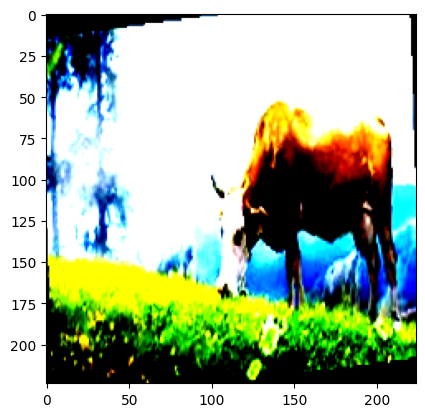

In [15]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

### Creating neural network using CNN for Classification

In [13]:
class AnimalClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [14]:
images.size(0)

32

In [15]:
len(train_loader.dataset)

19634

### Function for Training and validating Model performance

In [16]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [17]:
# Instantiate the model, loss function, and optimizer
model = AnimalClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 2.30
Batch: 20, Epoch: 1, Loss: 2.26
Batch: 30, Epoch: 1, Loss: 2.30
Batch: 40, Epoch: 1, Loss: 2.26
Batch: 50, Epoch: 1, Loss: 2.23
Batch: 60, Epoch: 1, Loss: 2.15
Batch: 70, Epoch: 1, Loss: 2.06
Batch: 80, Epoch: 1, Loss: 2.19
Batch: 90, Epoch: 1, Loss: 2.12
Batch: 100, Epoch: 1, Loss: 2.04
Batch: 110, Epoch: 1, Loss: 2.16
Batch: 120, Epoch: 1, Loss: 1.95
Batch: 130, Epoch: 1, Loss: 1.89
Batch: 140, Epoch: 1, Loss: 2.14
Batch: 150, Epoch: 1, Loss: 1.95
Batch: 160, Epoch: 1, Loss: 2.26
Batch: 170, Epoch: 1, Loss: 2.00
Batch: 180, Epoch: 1, Loss: 2.13
Batch: 190, Epoch: 1, Loss: 1.84
Batch: 200, Epoch: 1, Loss: 2.07
Batch: 210, Epoch: 1, Loss: 1.87
Batch: 220, Epoch: 1, Loss: 1.87
Batch: 230, Epoch: 1, Loss: 2.09
Batch: 240, Epoch: 1, Loss: 1.71
Batch: 250, Epoch: 1, Loss: 2.10
Batch: 260, Epoch: 1, Loss: 1.97
Batch: 270, Epoch: 1, Loss: 1.81
Batch: 280, Epoch: 1, Loss: 1.81
Batch: 290, Epoch: 1, Loss: 1.76
Batch: 300, Epoch: 1, Loss: 1.77
Batch: 310, Epoch: 

### Using Batch normalization and Dropouts

In [18]:
class AnimalClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

### weight decay as L2 regularization

In [19]:
model = AnimalClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=5)

Batch: 10, Epoch: 1, Loss: 14.25
Batch: 20, Epoch: 1, Loss: 6.94
Batch: 30, Epoch: 1, Loss: 2.85
Batch: 40, Epoch: 1, Loss: 2.23
Batch: 50, Epoch: 1, Loss: 2.33
Batch: 60, Epoch: 1, Loss: 2.25
Batch: 70, Epoch: 1, Loss: 2.18
Batch: 80, Epoch: 1, Loss: 2.37
Batch: 90, Epoch: 1, Loss: 2.18
Batch: 100, Epoch: 1, Loss: 2.24
Batch: 110, Epoch: 1, Loss: 2.30
Batch: 120, Epoch: 1, Loss: 2.24
Batch: 130, Epoch: 1, Loss: 2.08
Batch: 140, Epoch: 1, Loss: 2.11
Batch: 150, Epoch: 1, Loss: 2.12
Batch: 160, Epoch: 1, Loss: 2.10
Batch: 170, Epoch: 1, Loss: 2.12
Batch: 180, Epoch: 1, Loss: 2.05
Batch: 190, Epoch: 1, Loss: 2.14
Batch: 200, Epoch: 1, Loss: 1.99
Batch: 210, Epoch: 1, Loss: 2.14
Batch: 220, Epoch: 1, Loss: 2.07
Batch: 230, Epoch: 1, Loss: 2.09
Batch: 240, Epoch: 1, Loss: 2.14
Batch: 250, Epoch: 1, Loss: 2.11
Batch: 260, Epoch: 1, Loss: 1.94
Batch: 270, Epoch: 1, Loss: 2.15
Batch: 280, Epoch: 1, Loss: 2.04
Batch: 290, Epoch: 1, Loss: 2.01
Batch: 300, Epoch: 1, Loss: 1.99
Batch: 310, Epoch:

### Transfer Learning with ResNet

In [20]:
# Load the pre-trained ResNet model
class AnimalClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [21]:
model = AnimalClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 0.63
Batch: 20, Epoch: 1, Loss: 0.35
Batch: 30, Epoch: 1, Loss: 0.15
Batch: 40, Epoch: 1, Loss: 0.27
Batch: 50, Epoch: 1, Loss: 0.52
Batch: 60, Epoch: 1, Loss: 0.37
Batch: 70, Epoch: 1, Loss: 0.12
Batch: 80, Epoch: 1, Loss: 0.20
Batch: 90, Epoch: 1, Loss: 0.13
Batch: 100, Epoch: 1, Loss: 0.39
Batch: 110, Epoch: 1, Loss: 0.12
Batch: 120, Epoch: 1, Loss: 0.07
Batch: 130, Epoch: 1, Loss: 0.31
Batch: 140, Epoch: 1, Loss: 0.32
Batch: 150, Epoch: 1, Loss: 0.25
Batch: 160, Epoch: 1, Loss: 0.59
Batch: 170, Epoch: 1, Loss: 0.42
Batch: 180, Epoch: 1, Loss: 0.19
Batch: 190, Epoch: 1, Loss: 0.07
Batch: 200, Epoch: 1, Loss: 0.16
Batch: 210, Epoch: 1, Loss: 0.16
Batch: 220, Epoch: 1, Loss: 0.05
Batch: 230, Epoch: 1, Loss: 0.04
Batch: 240, Epoch: 1, Loss: 0.31
Batch: 250, Epoch: 1, Loss: 0.05
Batch: 260, Epoch: 1, Loss: 0.24
Batch: 270, Epoch: 1, Loss: 0.11
Batch: 280, Epoch: 1, Loss: 0.27
Batch: 290, Epoch: 1, Loss: 0.25
Batch: 300, Epoch: 1, Loss: 0.34
Batch: 310, Epoch: 

### Model Evaluation using Confusion Matrix and Classification Report

In [22]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       524
           1       0.97      0.95      0.96       401
           2       0.98      0.99      0.98       762
           3       0.94      0.94      0.94       464
           4       0.96      0.98      0.97      1241
           5       0.99      0.96      0.98       356
           6       0.96      0.97      0.97       665
           7       0.97      0.97      0.97       433
           8       0.99      0.99      0.99      1268
           9       0.98      0.97      0.98       431

    accuracy                           0.97      6545
   macro avg       0.97      0.97      0.97      6545
weighted avg       0.97      0.97      0.97      6545



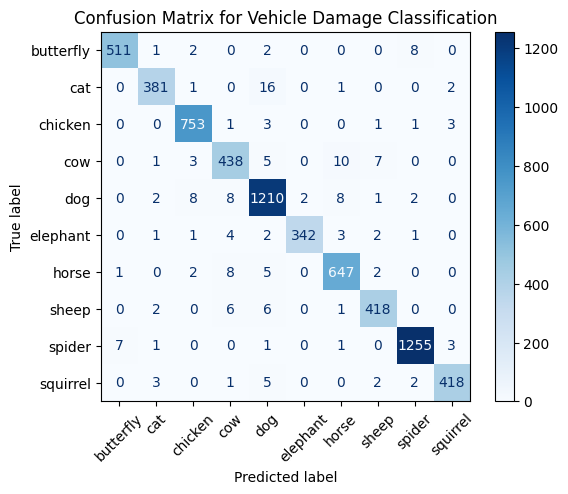

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [24]:
torch.save(model.state_dict(), 'saved_model.pth')